# LibCBM versus CBM-CFS3 Stand level testing

In [1]:
import os, json, math
import numpy as np
import pandas as pd
%matplotlib inline


libCBM related imports


In [2]:
from libcbm.test import casegeneration
from libcbm.test.cbm3support import cbm3_simulator
from libcbm.test import simulator
from libcbm.test import poolcomparison

In [3]:
age_interval=5
num_age_classes = 40 #required by cbm3
n_steps = 250
cbm3_exe_path = r"M:\CBM Tools and Development\Builds\CBMBuilds\20190530_growth_increment_fix"
toolbox_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3"
archive_index_db_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3\Admin\DBs\ArchiveIndex_Beta_Install.mdb"

cbm_defaults_db_path = 'C:\dev\cbm_defaults\cbm_defaults.db'
libcbm_path = r'C:\dev\LibCBM\LibCBM\x64\Debug\LibCBM.dll'

generate random test cases

In [4]:
cases = casegeneration.generate_scenarios(
    random_seed = 2,
    num_cases = 1,
    dbpath = 'C:\dev\cbm_defaults\cbm_defaults.db',
    n_steps=n_steps,
    max_disturbances = 3,
    max_components = 1,
    growth_generator = lambda: casegeneration.get_random_sigmoid_func,
    n_growth_digits = 2,
    age_interval=age_interval,
    max_age=age_interval*num_age_classes)


In [5]:
cases

[{'id': 1,
  'age': 0,
  'area': 1.0,
  'delay': 0,
  'unfccc_land_class': 0,
  'admin_boundary': 'Yukon Territory',
  'eco_boundary': 'Pacific Maritime',
  'historic_disturbance': 'Wildfire',
  'last_pass_disturbance': 'Wildfire',
  'components': [{'species': 'Shore pine',
    'age_volume_pairs': [(0, 0),
     (5, 0),
     (10, 0),
     (15, 0),
     (20, 0),
     (25, 0),
     (30, 0),
     (35, 0),
     (40, 0),
     (45, 465.77),
     (50, 465.77),
     (55, 465.77),
     (60, 465.77),
     (65, 465.77),
     (70, 465.77),
     (75, 465.77),
     (80, 465.77),
     (85, 465.77),
     (90, 465.77),
     (95, 465.77),
     (100, 465.77),
     (105, 465.77),
     (110, 465.77),
     (115, 465.77),
     (120, 465.77),
     (125, 465.77),
     (130, 465.77),
     (135, 465.77),
     (140, 465.77),
     (145, 465.77),
     (150, 465.77),
     (155, 465.77),
     (160, 465.77),
     (165, 465.77),
     (170, 465.77),
     (175, 465.77),
     (180, 465.77),
     (185, 465.77),
     (190, 4

In [6]:
libcbm_result = simulator.run_libCBM(libcbm_path, cbm_defaults_db_path, cases, n_steps)

In [7]:
project_path = cbm3_simulator.import_cbm3_project(
    name="growth_curve_testing",
    cases=cases,
    age_interval=age_interval,
    num_age_classes=num_age_classes,
    nsteps=n_steps,
    cbm_exe_path=cbm3_exe_path,
    toolbox_path=toolbox_path,
    archive_index_db_path=archive_index_db_path)

cbm3_results_path = cbm3_simulator.run_cbm3(
    aidb_path=archive_index_db_path, 
    project_path=project_path,
    toolbox_path=toolbox_path,
    cbm_exe_path=cbm3_exe_path)

cbm3_result = cbm3_simulator.get_cbm3_results(cbm3_results_path)

In [8]:
pools_merged, pool_diffs = poolcomparison.join_pools(libcbm_result["pools"], cbm3_result["pools"], "all")

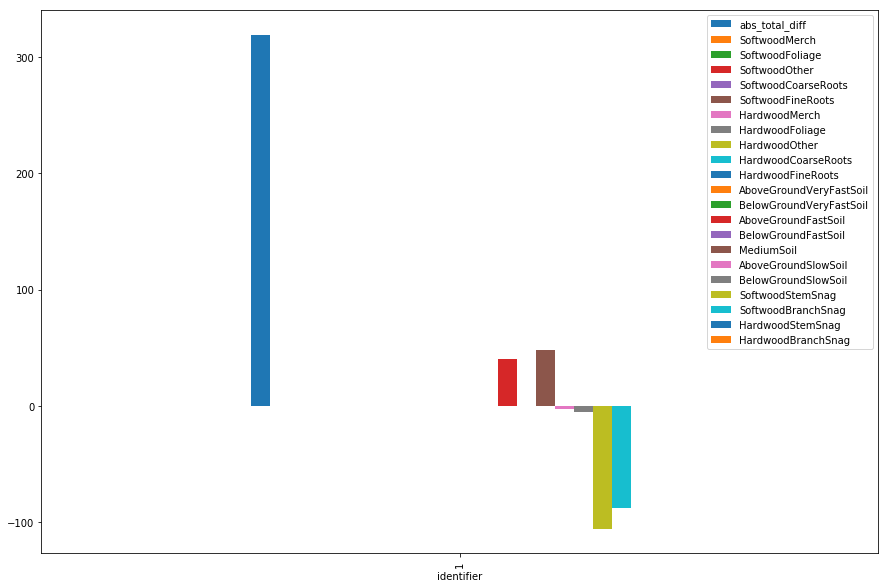

In [9]:
pool_diffs_totals = pool_diffs.drop(columns="timestep")
pool_diffs_totals \
    .groupby("identifier").sum() \
    .sort_values("abs_total_diff", ascending=False) \
    .head(20) \
    .plot(figsize=(15,10), kind="bar")

In [10]:
def plot_diff(id):
    markers = ["o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d"]
    bio_pools = pools_merged[pools_merged["identifier"]==casegeneration.get_classifier_name(id)]
    bio_pools = bio_pools.drop(columns="identifier")
    bio_pools = bio_pools.groupby("timestep").sum()
    ax = bio_pools.plot(figsize=(15,12), title=casegeneration.get_classifier_name(id))
    for i, line in enumerate(ax.get_lines()):
        line.set_marker(markers[i%len(markers)])
    ax.legend(ax.get_lines(), bio_pools.columns, loc='best')
    bio_diffs = pool_diffs[pool_diffs["identifier"]==casegeneration.get_classifier_name(id)]
    bio_diffs.drop(columns="identifier")
    bio_diffs.groupby("timestep").sum() \
        .plot(figsize=(15,12), title=casegeneration.get_classifier_name(id))

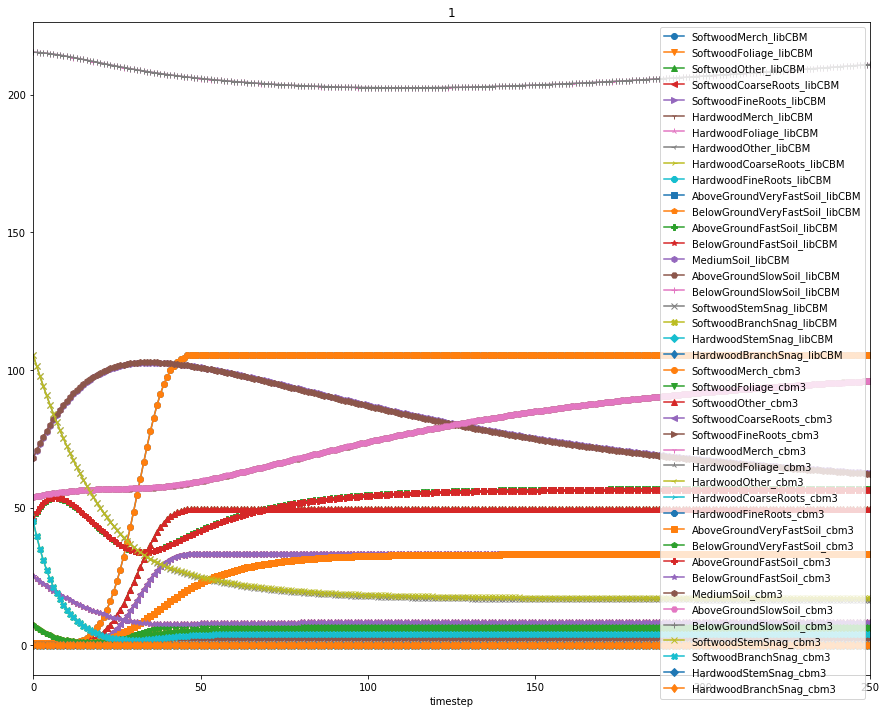

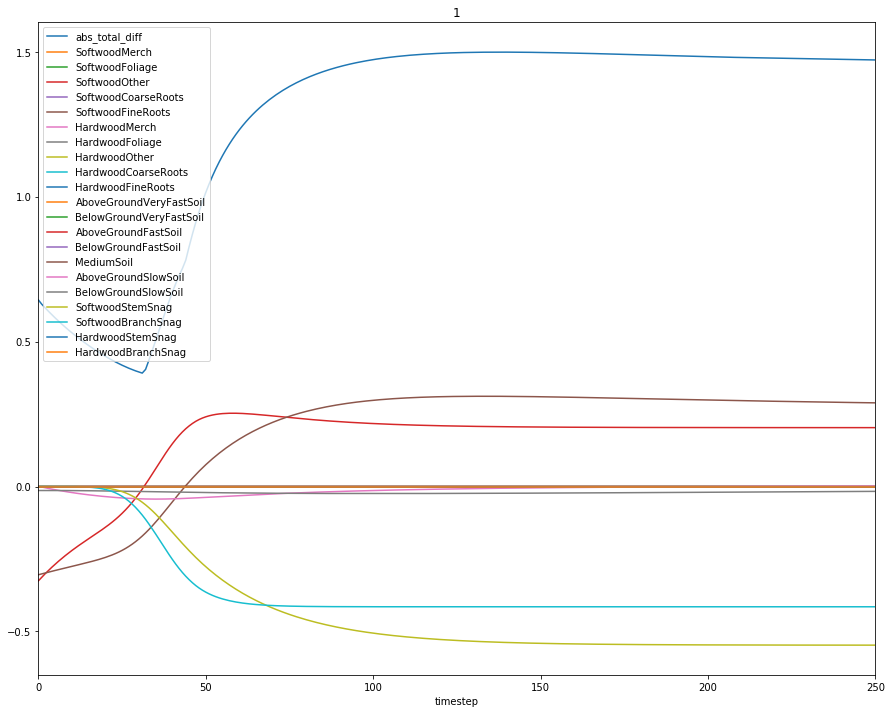

In [11]:
plot_diff(1)

In [ ]:
db_path =
n_steps = 225

age_interval = 5 #required by cbm3


cbm3_results_db_path = run_CBM3(cases, age_interval, num_age_classes, n_steps)
cbm3_pool_result = cbm3_results.load_pool_indicators(cbm3_results_db_path, classifier_set_grouping=True)

In [ ]:
cases = generate_scenarios(random_seed=1, num_cases=10, dbpath=db_path, ndigits=2)

In [8]:
libCBM_result = run_libCBM(db_path, cases, n_steps, spinup_debug=True)
libCBM_pool_result = libCBM_result["pools"]
libCBM_pool_result["identifier"] = (libCBM_pool_result["index"]+1).apply(get_classifier_name)
libCBM_spinup_debug = libCBM_result["spinup_debug"]

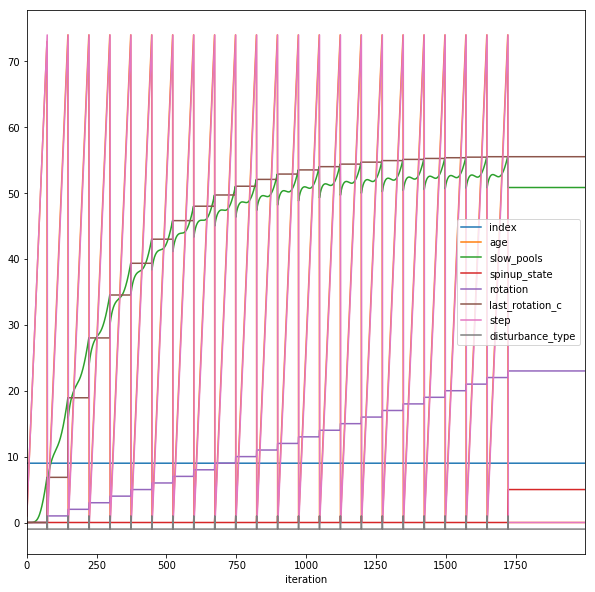

In [9]:
libCBM_spinup_debug[libCBM_spinup_debug["index"]==9].groupby("iteration").sum().plot(figsize=(10,10))

In [11]:
list(cbm3_pool_result)

['TimeStep',
 'UserDefdClassSetID',
 'Aboveground Very Fast DOM',
 'Belowground Very Fast DOM',
 'Aboveground Fast DOM',
 'Belowground Fast DOM',
 'Medium DOM',
 'Aboveground Slow DOM',
 'Belowground Slow DOM',
 'Softwood Stem Snag',
 'Softwood Branch Snag',
 'Hardwood Stem Snag',
 'Hardwood Branch Snag',
 'BlackCarbon',
 'Peat',
 'Softwood Merchantable',
 'Softwood Foliage',
 'Softwood Other',
 'Softwood Coarse Roots',
 'Softwood Fine Roots',
 'Hardwood Merchantable',
 'Hardwood Foliage',
 'Hardwood Other',
 'Hardwood Coarse Roots',
 'Hardwood Fine Roots',
 'Total Biomass',
 'Aboveground Biomass',
 'Belowground Biomass',
 'Total Ecosystem',
 'Dead Organic Matter',
 'Aboveground DOM',
 'Belowground DOM',
 'Deadwood',
 'Litter',
 'Soil C',
 'admin',
 'eco',
 'identifier',
 'species']

In [ ]:
merged.transpose()

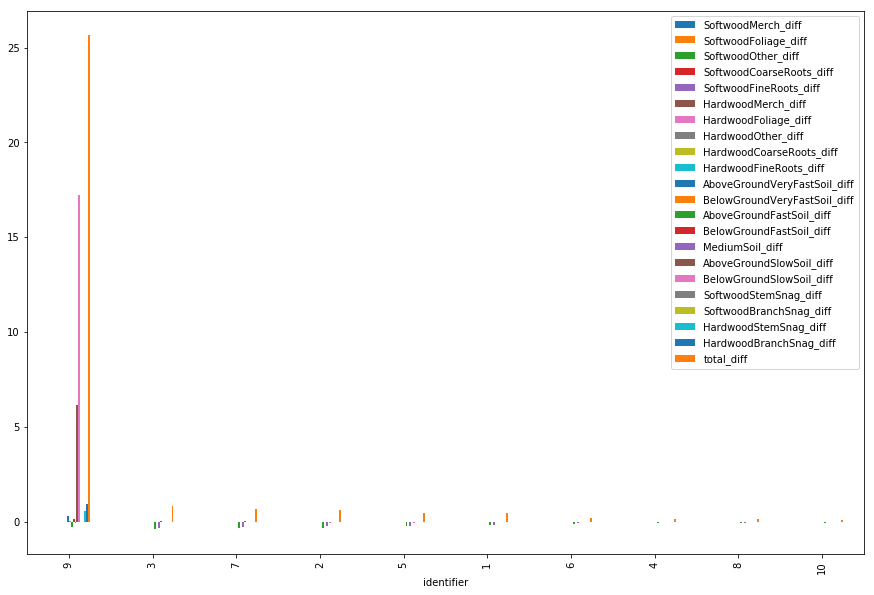

In [14]:
merged[["identifier"]+diff_colnames+["total_diff"]] \
    .groupby("identifier").sum() \
    .sort_values("total_diff", ascending=False) \
    .head(20) \
    .plot(figsize=(15,10), kind="bar")

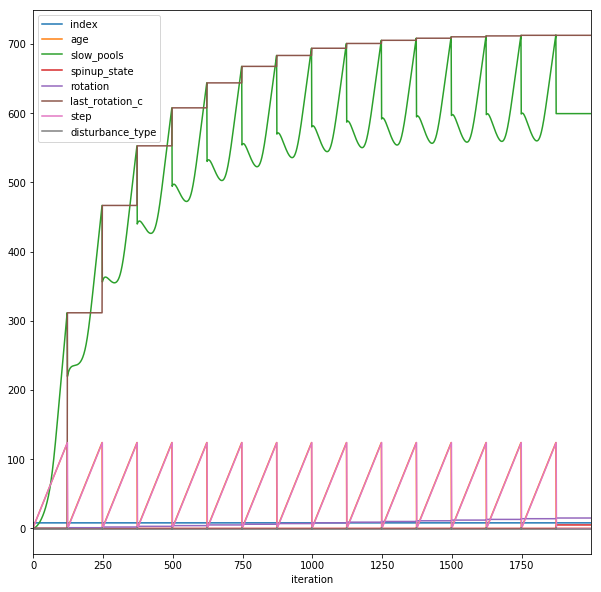

In [18]:
libCBM_spinup_debug.loc[libCBM_spinup_debug["index"]==8] \
    .groupby("iteration").sum().plot(figsize=(10,10))

In [16]:
libCBM_pool_result.tail()

,index,age,timestep,Input,SoftwoodMerch,SoftwoodFoliage,SoftwoodOther,SoftwoodCoarseRoots,SoftwoodFineRoots,HardwoodMerch,...,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products,identifier
5,5,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44.918237,7.443656,45.224323,15.663548,6865.289482,9.972763,89.758173,0.0,0.0,6
6,6,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,76.225722,15.160703,70.115621,29.222043,15910.635258,13.988588,125.901234,0.0,0.0,7
7,7,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44.032638,10.142715,0.000000,0.000000,3142.167075,5.640674,50.763544,0.0,0.0,8
8,8,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50.203792,13.681528,118.443957,79.562792,41304.895038,48.373020,435.351560,0.0,0.0,9
9,9,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,43.444181,8.621647,0.000000,0.000000,2850.452787,5.082038,45.735731,0.0,0.0,10


In [17]:
cbm3_result

NameError: name 'cbm3_result' is not defined